<a href="https://colab.research.google.com/github/camoalon/language_genes/blob/master/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages and data

## Import packages

In [0]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

## Define Procrustes

In [0]:
def procrustess(X, Y, scaling=True, reflection='best'):
    """
    A port of MATLAB's `procrustes` function to Numpy.

    Procrustes analysis determines a linear transformation (translation,
    reflection, orthogonal rotation and scaling) of the points in Y to best
    conform them to the points in matrix X, using the sum of squared errors
    as the goodness of fit criterion.

        d, Z, [tform] = procrustes(X, Y)

    Inputs:
    ------------
    X, Y    
        matrices of target and input coordinates. they must have equal
        numbers of  points (rows), but Y may have fewer dimensions
        (columns) than X.

    scaling 
        if False, the scaling component of the transformation is forced
        to 1

    reflection
        if 'best' (default), the transformation solution may or may not
        include a reflection component, depending on which fits the data
        best. setting reflection to True or False forces a solution with
        reflection or no reflection respectively.

    Outputs
    ------------
    d       
        the residual sum of squared errors, normalized according to a
        measure of the scale of X, ((X - X.mean(0))**2).sum()

    Z
        the matrix of transformed Y-values

    tform   
        a dict specifying the rotation, translation and scaling that
        maps X --> Y

    """

    n,m = X.shape
    ny,my = Y.shape

    muX = X.mean(0)
    muY = Y.mean(0)

    X0 = X - muX
    Y0 = Y - muY

    ssX = (X0**2.).sum()
    ssY = (Y0**2.).sum()

    # centred Frobenius norm
    normX = np.sqrt(ssX)
    normY = np.sqrt(ssY)

    # scale to equal (unit) norm
    X0 /= normX
    Y0 /= normY

    if my < m:
        Y0 = np.concatenate((Y0, np.zeros(n, m-my)),0)

    # optimum rotation matrix of Y
    A = np.dot(X0.T, Y0)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)

    if reflection is not 'best':

        # does the current solution use a reflection?
        have_reflection = np.linalg.det(T) < 0

        # if that's not what was specified, force another reflection
        if reflection != have_reflection:
            V[:,-1] *= -1
            s[-1] *= -1
            T = np.dot(V, U.T)

    traceTA = s.sum()

    if scaling:

        # optimum scaling of Y
        b = traceTA * normX / normY

        # standarised distance between X and b*Y*T + c
        d = 1 - traceTA**2

        # transformed coords
        Z = normX*traceTA*np.dot(Y0, T) + muX

    else:
        b = 1
        d = 1 + ssY/ssX - 2 * traceTA * normY / normX
        Z = normY*np.dot(Y0, T) + muX

    # transformation matrix
    if my < m:
        T = T[:my,:]
    c = muX - b*np.dot(muY, T)

    #transformation values 
    tform = {'rotation':T, 'scale':b, 'translation':c}

    return d, Z, tform

## Import data

In [0]:
file = 'https://raw.githubusercontent.com/camoalon/language_genes/master/data/Phonemes139forShannon.txt?token=AIVRZB6YJG6TW6QCKV67WEC6RJRWY'
phonemes = pd.read_csv(file,sep='\t',header=None)
phonemes.drop(139,axis=1,inplace=True)

In [0]:
file = 'https://raw.githubusercontent.com/camoalon/language_genes/master/data/LongLat_Unscaled_139forShannon.txt?token=AIVRZBZWC346DX4G7TPBWIC6RKEMM'
coordinates = pd.read_csv(file,sep='\t',header=None)
coordinates.drop(139,axis=1,inplace=True)


# Perform analysis

## PCA

In [0]:
pca = PCA()
pca.fit(phonemes.T)
pca_data = pca.transform(phonemes.T)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

phonemes_pca = pd.DataFrame(pca_data, columns=labels)

phonemes_pc = pd.DataFrame([phonemes_pca.PC1, phonemes_pca.PC2]).T

## Procrustes

In [0]:
d, Z, t = procrustess(coordinates.T.values, phonemes_pc.T.values)

# Plot the results

Text(0, 0.5, 'PC2 - 7.5%')

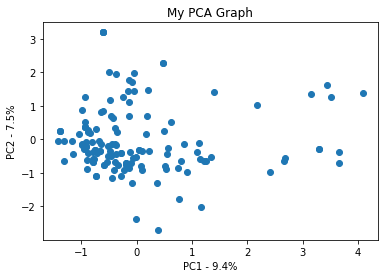

In [156]:
plt.scatter(phonemes_pc['PC1'], phonemes_pc['PC2'])
plt.title('My PCA Graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

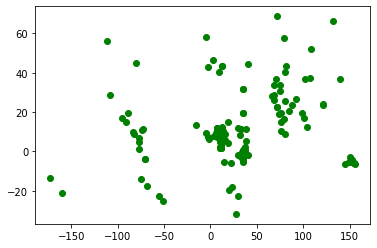

In [134]:
plt.scatter(coordinates.T[0], coordinates.T[1], c = "g")

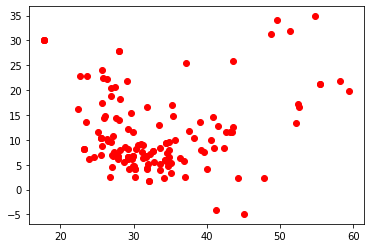

In [136]:
plt.scatter(Z.T[0], Z.T[1], c = "r")

# Ejemplo de Matlab

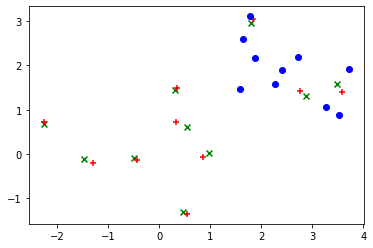

In [115]:
X = np.array([[0.5377,
    1.8339,
   -2.2588,
    0.8622,
    0.3188,
   -1.3077,
   -0.4336,
    0.3426,
    3.5784,
    2.7694],
    [ -1.3499,
    3.0349,
    0.7254,
   -0.0631,
    0.7147,
   -0.2050,
   -0.1241,
    1.4897,
    1.4090,
    1.4172]])

Y = np.array([[1.5835,
    3.7123,
    1.7853,
    2.2698,
    2.4136,
    1.6361,
    1.8742,
    2.7155,
    3.5194,
    3.2667],[    1.4741,
    1.9073,
    3.1060,
    1.5704,
    1.8934,
    2.5869,
    2.1730,
    2.1863,
    0.8713,
    1.0695]])


d, Z, tr = procrustess (X.T,Y.T)

plt.scatter(Z.T[0], Z.T[1], c = "g", marker = "x")
plt.scatter(X[0], X[1], c = "r", marker = "+")
plt.scatter(Y[0], Y[1], c = "b")

